# Pipelines
* Recent: less than 30 days
* Old: 30 days
* Stale: 90 days

In [31]:
# include common code and config
# selected_pi = 14
%run PIQM_Bootstrap.ipynb

{'pi': 'PI13', 'id': 13, 'start': '2021-12-17T00:00:00Z', 'started': '2021-12-17', 'finish': '2022-03-18T23:59:59Z'}


In [32]:
# MVP related projects
project_ids = [ 11448712, # ska-skampi
                9027158,  # ska-tango-images
                23023505, # ska-tmc-centralnode
                21141217, # sdp/ska-sdp-integration
                32606296, # ska-tango-taranta-group/ska-tango-taranta-pipeline
                32606403, # ska-tango-taranta-group/ska-tango-taranta-auth-pipeline
                32606458, # ska-tango-taranta-group/ska-tango-taranta-dashboard-pipeline
                17415960, # ska-ser-skuid
                15858077, # ska-dish-lmc
                10593884, # ska-sim-dishmaster
                23023437, # ska-tmc-subarraynode
                10749136, # ska-tmc
                21173098  # ska-ser-skallop
              ]



In [33]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "projects" and r._field == "pipeline_last_run_finished")
        |> drop(columns:["_measurement", "_field", "_time", "_start", "_stop"])
        |> group()""".format(current_pi))
# .agg(['count', 'size', 'nunique'])
df_pipeline_status = df_pipelines[["pipeline_last_run_status", "_value"]].groupby(["pipeline_last_run_status"]).agg(['count', 'size', 'nunique']).reset_index()
df_pipeline_status['pipeline_last_run_status'] = df_pipeline_status['pipeline_last_run_status'].str.title()
df_pipeline_status['count'] = df_pipeline_status['_value']['count']
# print(df_pipeline_status)
old_threshold = 30 * 24 * 60 * 60 # 30 days
stale_threshold = 90 * 24 * 60 * 60 # 90 days
df_pipelines['age'] = current_timestamp - df_pipelines['_value']
df_pipelines["stale_pipeline"] = pandas.cut(x=df_pipelines['age'],
                                            bins=[0, 1, old_threshold, stale_threshold, float('Inf')],
                                            labels=['Never', 'Recent', 'Old', 'Stale'], right=False)

df_pipelines.loc[df_pipelines['_value'] < 1,'stale_pipeline'] = 'Never'
df_pipelines['how_many'] = 1
df_pipelines['total'] = 'Total'
df_pipelines

result  table        _value got_coverage got_linting got_rtd got_tests  \
0    _result      0  1.645592e+09            0           0       0         0   
1    _result      0  1.645384e+09            0           0       0         0   
2    _result      0  0.000000e+00            0           0       0         0   
3    _result      0  1.631095e+09            0           0       0         0   
4    _result      0  0.000000e+00            0           0       0         0   
..       ...    ...           ...          ...         ...     ...       ...   
227  _result      0  1.645482e+09            1           1       1         1   
228  _result      0  1.645585e+09            1           1       1         1   
229  _result      0  1.644215e+09            1           1       1         1   
230  _result      0  1.645029e+09            1           1       1         1   
231  _result      0  1.645392e+09            1           1       1         1   

           id       license pipeline_last_run_status  \
0    12828461    apache-2.0                  success   
1    13372840  bsd-3-clause                  success   
2    13540781  bsd-3-clause                  pending   
3    14333804  bsd-3-clause                   failed   
4    15077844  bsd-3-clause                  unknown   
..        ...           ...                      ...   
227  30178128         other                  success   
228  30412954         other                  success   
229  33186816         other                  success   
230   9027158         other                  success   
231   9673989         other                  success   

                                           project           age  \
0              ska-telescope/sdp/ska-sdp-par-model  3.239413e+04   
1            ska-telescope/ska-cicd-cpp-build-base  2.400113e+05   
2         ska-telescope/templates/ska-cpp-template  1.645624e+09   
3                        ska-telescope/sdc/ska-sdc  1.452856e+07   
4                 ska-telescope/CUDA_Deconvolution  1.645624e+09   
..                                             ...           ...   
227                 ska-telescope/ska-low-cbf-fpga  1.417421e+05   
228  ska-telescope/sdp/ska-sdp-ms-add-derived-data  3.885731e+04   
229                 ska-telescope/ska-low-cbf-conn  1.408627e+06   
230                 ska-telescope/ska-tango-images  5.948430e+05   
231               ska-telescope/ska-tango-examples  2.323075e+05   

    stale_pipeline  how_many  total  
0           Recent         1  Total  
1           Recent         1  Total  
2            Never         1  Total  
3            Stale         1  Total  
4            Never         1  Total  
..             ...       ...    ...  
227         Recent         1  Total  
228         Recent         1  Total  
229         Recent         1  Total  
230         Recent         1  Total  
231         Recent         1  Total  

[232 rows x 15 columns]

In [34]:
df_state_age = df_pipelines[["pipeline_last_run_status", "stale_pipeline", "id"]]\
    .groupby(["pipeline_last_run_status", "stale_pipeline"])\
    .agg(['count', 'size', 'nunique']).reset_index()
df_state_age['count'] = df_state_age['id']['count']
# .agg(['count', 'size', 'nunique'])
# df_state_age = df_state_age[df_state_age["id"] != 0]

df_state_age = df_state_age[["pipeline_last_run_status", "stale_pipeline", "count"]]\
    .rename(columns={"pipeline_last_run_status": "Last run status", "stale_pipeline": "Stale"})\
    .sort_values(["count"], ascending=False)

df_state_age.style.hide_index()\
    .set_properties(subset=['Last run status', 'Stale'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('SKA Pipeline Last Run')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


# df_state_age


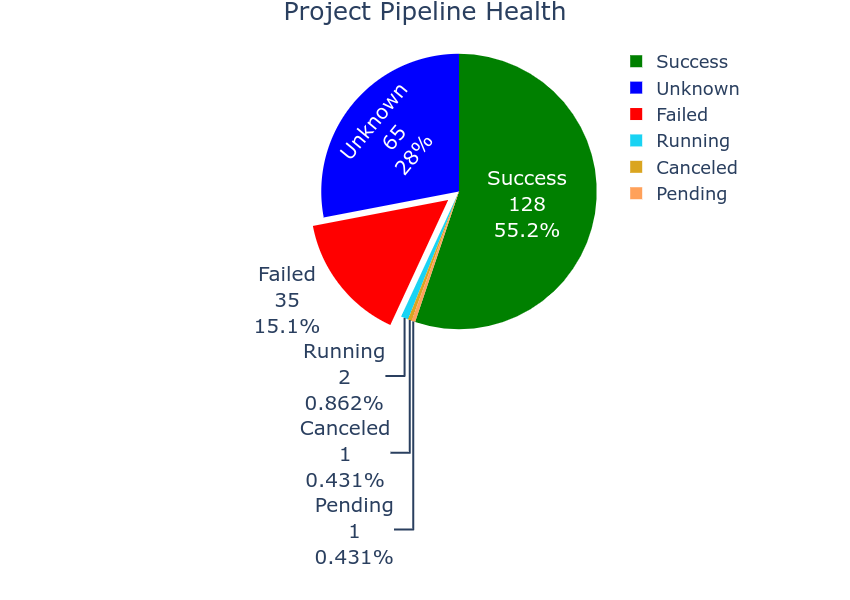

In [35]:
fig = px.pie(df_pipeline_status, values='count',
             names='pipeline_last_run_status',
             title='Project Pipeline Health',
             color='pipeline_last_run_status', 
#              color_discrete_sequence=px.colors.sequential.RdBu)
             color_discrete_map={
                "Success": "green",
                "Unknown": "blue",
                "Failed": "red",
                "Canceled": "goldenrod"})
fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', 
                  font=dict(size=18,), 
                  margin = dict(t=40, l=0, r=0, b=0),
                 legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.80
                    ))
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent+label', textfont_size=20, pull=[0, 0.1, 0, 0])
fig.show()


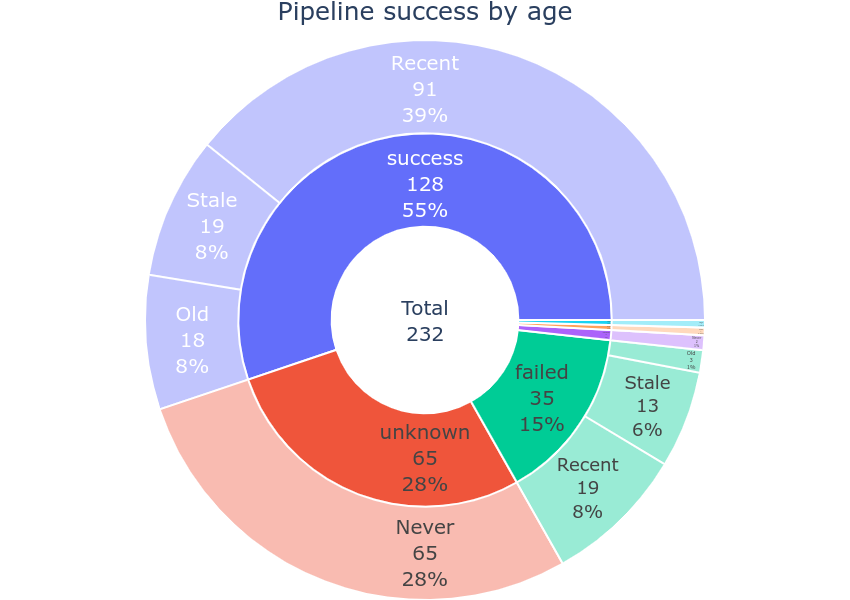

In [36]:
import plotly.express as px
fig = px.sunburst(df_pipelines, 
                  title="Pipeline success by age",
                  height=600,
                  path=['total', 'pipeline_last_run_status', 'stale_pipeline'], 
                  values='how_many', 
                  branchvalues="total",
#                  color_discrete_map={'Total': 'white'}
                 )


fig.update_traces(textinfo='label+value+percent entry', 
                  textfont_size=20, 
                  insidetextorientation='horizontal',
                  leaf={'opacity': 0.4},
                  marker={'line': {'width': [2 for i in range(len(df_pipelines))], 'color': '#fff'}},
                 )

fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=18,),
                  margin = dict(t=40, l=0, r=0, b=0),)

fig.show()

In [37]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_skampi_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success" and r.project == "ska-telescope/ska-skampi")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "project", "project_id"])
        |> group()""".format(current_pi))
df_skampi_pipelines

result  table                            _time  _value      created_by  \
0     _result      0 2021-07-26 14:56:57.599000+00:00    53.0   Bruno_Ribeiro   
1     _result      0 2020-02-03 08:54:47.585000+00:00     0.0  DigvijayMali92   
2     _result      0 2020-02-10 14:14:27.632000+00:00     0.0  DigvijayMali92   
3     _result      0 2020-09-22 10:00:53.339000+00:00     0.0  DigvijayMali92   
4     _result      0 2020-09-22 10:10:08.975000+00:00     0.0  DigvijayMali92   
...       ...    ...                              ...     ...             ...   
3468  _result      0 2019-12-20 16:20:43.799000+00:00     0.0           vla22   
3469  _result      0 2021-07-21 09:04:27.426000+00:00    70.0           vla22   
3470  _result      0 2020-07-29 13:46:59.060000+00:00     0.0        widaborz   
3471  _result      0 2020-07-29 14:08:09.493000+00:00     0.0        widaborz   
3472  _result      0 2021-04-27 08:28:16.212000+00:00    17.0        widaborz   

     passed pipeline_id     ref    status  
0     False   341763274  master    failed  
1     False   114427322  master   success  
2     False   116545177  master   success  
3     False   192897538  master  canceled  
4     False   192920007  master  canceled  
...     ...         ...     ...       ...  
3468  False   104682167  master   success  
3469  False   340452105  master   success  
3470  False   171725838  master   success  
3471  False   172114380  master   success  
3472  False   292868336  master    failed  

[3473 rows x 9 columns]

In [38]:
from datetime import datetime
import pandas as pd
current_timestamp = int(datetime.now().timestamp())

query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "_value", "table", "result", "index"])
        |> group()""".format(current_pi))

df_pipelines["project_id"] = pd.to_numeric(df_pipelines["project_id"])
df_pipelines = df_pipelines[df_pipelines.project_id.isin(project_ids)].reset_index()
# df_pipelines[df_pipelines.project == "ska-telescope/ska-skampi"]
df_pipelines['project'] = df_pipelines['project'].str[14:]
df_pipelines


index   result  table                            _time      created_by  \
0       49  _result      0 2022-01-06 12:21:01.422000+00:00       HFRibeiro   
1       50  _result      0 2022-01-06 12:23:46.059000+00:00       HFRibeiro   
2       51  _result      0 2022-01-06 12:43:26.010000+00:00       HFRibeiro   
3       52  _result      0 2022-01-06 12:48:09.659000+00:00       HFRibeiro   
4       53  _result      0 2022-01-06 12:51:45.315000+00:00       HFRibeiro   
..     ...      ...    ...                              ...             ...   
286   2006  _result      0 2022-01-25 11:18:58.665000+00:00  shraddhabajare   
287   2007  _result      0 2022-01-31 13:19:59.803000+00:00  shraddhabajare   
288   2008  _result      0 2022-02-02 05:53:48.994000+00:00  shraddhabajare   
289   2279  _result      0 2022-02-14 09:10:41.907000+00:00        widaborz   
290   2280  _result      0 2022-02-14 09:33:05.016000+00:00        widaborz   

    passed pipeline_id                                            project  \
0    False   442641219  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1    False   442641988  ska-tango-taranta-group/ska-tango-taranta-pipe...   
2    False   442652460  ska-tango-taranta-group/ska-tango-taranta-pipe...   
3    False   442654254  ska-tango-taranta-group/ska-tango-taranta-pipe...   
4    False   442658491  ska-tango-taranta-group/ska-tango-taranta-pipe...   
..     ...         ...                                                ...   
286   True   455733750                                            ska-tmc   
287   True   459995869                                            ska-tmc   
288   True   461472175                                            ska-tmc   
289  False   470269449  ska-tango-taranta-group/ska-tango-taranta-pipe...   
290  False   470278955  ska-tango-taranta-group/ska-tango-taranta-pipe...   

     project_id     ref   status  
0      32606296    main   failed  
1      32606296    main   failed  
2      32606296    main   failed  
3      32606296    main   failed  
4      32606296    main   failed  
..          ...     ...      ...  
286    10749136  master  success  
287    10749136  master  success  
288    10749136  master  success  
289    32606296    main   failed  
290    32606296    main  success  

[291 rows x 11 columns]

In [39]:
df_mvp_pipelines = df_pipelines[["_time", "status", "project"]].reset_index()
df_mvp_pipelines = df_mvp_pipelines.rename(columns={"_time": "time"})
df_mvp_pipelines.sort_values(by=['project', 'time'], ascending=[True, True], inplace=True)
df_mvp_pipelines['colour'] = df_mvp_pipelines['status'].apply(lambda x: 'green' if x == 'success' else 'red')
df_mvp_pipelines['size'] = df_mvp_pipelines['status'].apply(lambda x: 4 ** 2 if x == 'success' else 10 ** 2)
df_mvp_pipelines

index                             time   status                  project  \
229    229 2022-01-24 16:25:06.553000+00:00  success  sdp/ska-sdp-integration   
230    230 2022-01-24 17:15:23.004000+00:00  success  sdp/ska-sdp-integration   
276    276 2022-01-27 15:08:48.452000+00:00  success  sdp/ska-sdp-integration   
231    231 2022-02-10 16:24:52.810000+00:00  success  sdp/ska-sdp-integration   
232    232 2022-02-14 10:46:09.902000+00:00  success  sdp/ska-sdp-integration   
..     ...                              ...      ...                      ...   
80      80 2022-01-25 14:55:42.376000+00:00  success     ska-tmc-subarraynode   
81      81 2022-01-28 10:30:39.413000+00:00  success     ska-tmc-subarraynode   
82      82 2022-01-28 14:55:54.995000+00:00  success     ska-tmc-subarraynode   
83      83 2022-02-03 08:18:15.416000+00:00  success     ska-tmc-subarraynode   
65      65 2022-02-03 08:19:31.221000+00:00  success     ska-tmc-subarraynode   

    colour  size  
229  green    16  
230  green    16  
276  green    16  
231  green    16  
232  green    16  
..     ...   ...  
80   green    16  
81   green    16  
82   green    16  
83   green    16  
65   green    16  

[291 rows x 6 columns]

In [40]:
projects = df_mvp_pipelines['project'].unique()
projects = list(reversed(["ska-skampi"] + sorted(list(filter(lambda x: not x == "ska-skampi", projects)))))
projects

['ska-tmc-subarraynode',
 'ska-tmc-centralnode',
 'ska-tmc',
 'ska-tango-taranta-group/ska-tango-taranta-pipeline',
 'ska-tango-taranta-group/ska-tango-taranta-dashboard-pipeline',
 'ska-tango-taranta-group/ska-tango-taranta-auth-pipeline',
 'ska-tango-images',
 'ska-sim-dishmaster',
 'ska-ser-skuid',
 'ska-ser-skallop',
 'ska-dish-lmc',
 'sdp/ska-sdp-integration',
 'ska-skampi']

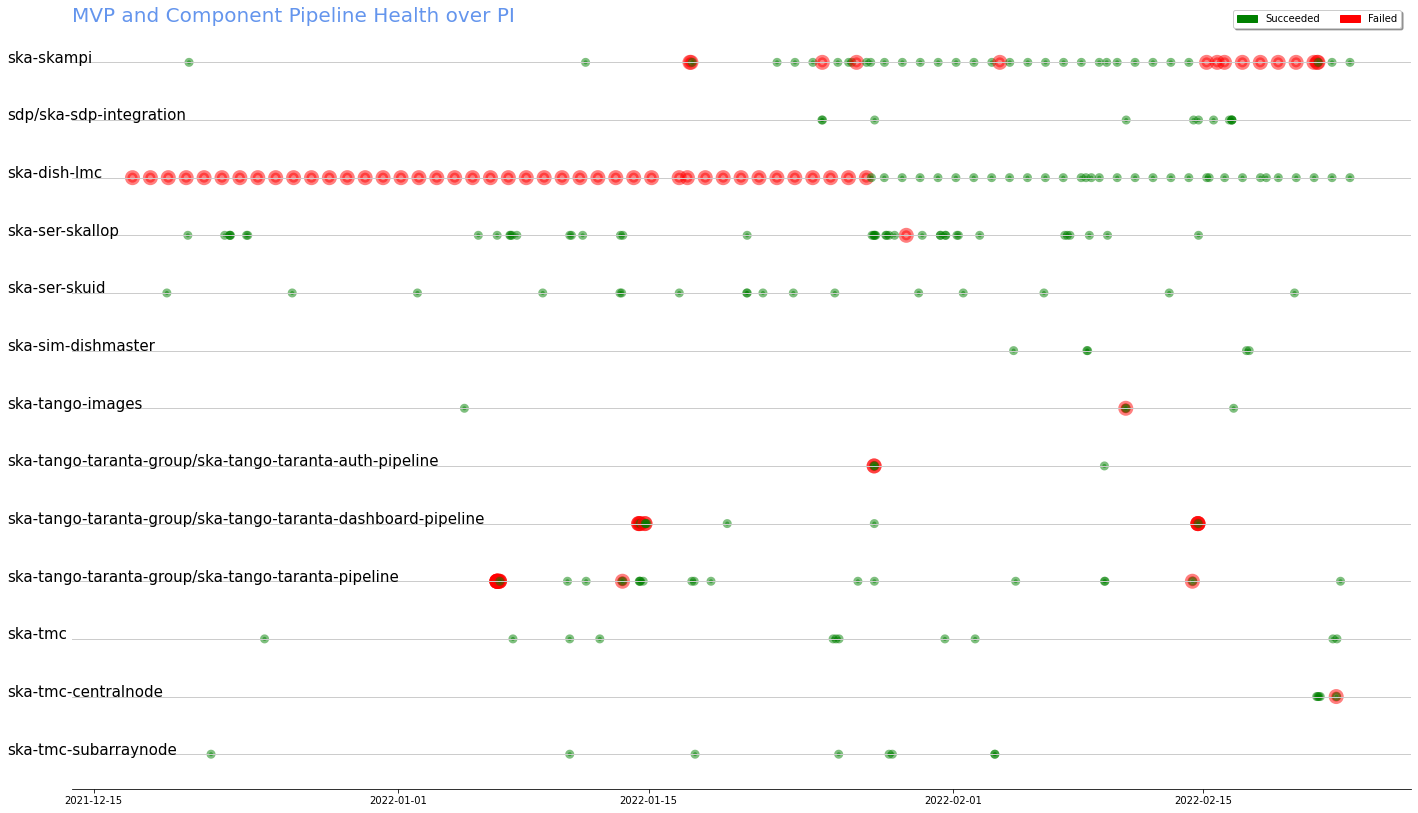

In [41]:
# https://stackoverflow.com/questions/44951911/plot-a-binary-timeline-in-matplotlib

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
plt.title('MVP and Component Pipeline Health over PI', fontsize=20, color='cornflowerblue', loc='left')
ax.yaxis.set_visible(False)
ax.get_yaxis().set_ticklabels([])

handles = []
handle = mpatches.Patch(color='green', label='Succeeded')
handles.append(handle)
handle = mpatches.Patch(color='red', label='Failed')
handles.append(handle)
    
ax.legend(
    handles=handles, 
    ncol=len(handles), loc='upper center', bbox_to_anchor=(0.93, 1.03),
          fancybox=True, shadow=True)

#Stile ticks
# fig.autofmt_xdate()


cnt = 0
for proj in projects:
    data = df_mvp_pipelines[df_mvp_pipelines.project == proj]
    cnt = cnt + 1
    pos = cnt*2
    ax.scatter(
        data['time'].tolist(),
        [pos] * data.shape[0],
        c=data['colour'].tolist(),
        s=data['size'].tolist(),
        marker='o',
        linewidth=5,
        alpha=.5)
    
    ax.axhline(
        pos, 
        linewidth=1,
        c='#CCCCCC')
    
    min_date = df_mvp_pipelines['time'].min()
    days = timedelta(days=7)
    ax.annotate(
        proj, 
        (min_date - days, pos),
        fontsize=15, annotation_clip=False)
    
fig.set_size_inches(24, 14)
# ax.get_yaxis().set_visible(False)
# ax.axis('off')
fig
#Hide spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


In [42]:

query_api = client.query_api()
df_pipelines_all = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> drop(columns:["_measurement", "_start", "_stop", "table", "result", "index"])
        |> group()""".format(current_pi))

df_pipelines_all["project_id"] = pd.to_numeric(df_pipelines_all["project_id"])
df_pipelines_all = df_pipelines_all[df_pipelines_all.project_id.isin(project_ids)].reset_index()
# df_pipelines_all[df_pipelines_all.project == "ska-telescope/ska-skampi"]
df_pipelines_all['project'] = df_pipelines_all['project'].str[14:]
df_pipelines_all


index   result  table                            _time  _value  \
0        49  _result      0 2022-01-06 12:21:01.422000+00:00     0.0   
1        50  _result      0 2022-01-06 12:23:46.059000+00:00     0.0   
2        51  _result      0 2022-01-06 12:43:26.010000+00:00     0.0   
3        52  _result      0 2022-01-06 12:48:09.659000+00:00     0.0   
4        53  _result      0 2022-01-06 12:51:45.315000+00:00     0.0   
...     ...      ...    ...                              ...     ...   
2614  20278  _result      0 2022-01-25 11:18:58.665000+00:00    53.0   
2615  20279  _result      0 2022-01-31 13:19:59.803000+00:00    53.0   
2616  20280  _result      0 2022-02-02 05:53:48.994000+00:00    54.0   
2617  20551  _result      0 2022-02-14 09:10:41.907000+00:00     0.0   
2618  20552  _result      0 2022-02-14 09:33:05.016000+00:00     0.0   

            _field      created_by passed pipeline_id  \
0         coverage       HFRibeiro  False   442641219   
1         coverage       HFRibeiro  False   442641988   
2         coverage       HFRibeiro  False   442652460   
3         coverage       HFRibeiro  False   442654254   
4         coverage       HFRibeiro  False   442658491   
...            ...             ...    ...         ...   
2614  test_success  shraddhabajare   True   455733750   
2615  test_success  shraddhabajare   True   459995869   
2616  test_success  shraddhabajare   True   461472175   
2617  test_success        widaborz  False   470269449   
2618  test_success        widaborz  False   470278955   

                                                project  project_id     ref  \
0     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
1     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
2     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
3     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
4     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
...                                                 ...         ...     ...   
2614                                            ska-tmc    10749136  master   
2615                                            ska-tmc    10749136  master   
2616                                            ska-tmc    10749136  master   
2617  ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
2618  ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   

       status  
0      failed  
1      failed  
2      failed  
3      failed  
4      failed  
...       ...  
2614  success  
2615  success  
2616  success  
2617   failed  
2618  success  

[2619 rows x 13 columns]

In [43]:
import numpy as np
pass_rate_table = pd.pivot_table(df_pipelines_all[df_pipelines_all.status == "success"], values='_value', index=['project', '_time'],
                    columns=['_field'], aggfunc=np.sum)
pass_rate_table

_field                                                    coverage  duration  \
project                 _time                                                  
sdp/ska-sdp-integration 2022-01-24 16:25:06.553000+00:00       0.0     494.0   
                        2022-01-24 17:15:23.004000+00:00       0.0     514.0   
                        2022-01-27 15:08:48.452000+00:00       0.0     414.0   
                        2022-02-10 16:24:52.810000+00:00       0.0     294.0   
                        2022-02-14 10:46:09.902000+00:00       0.0     546.0   
...                                                            ...       ...   
ska-tmc-subarraynode    2022-01-25 14:55:42.376000+00:00       0.0     507.0   
                        2022-01-28 10:30:39.413000+00:00       0.0     581.0   
                        2022-01-28 14:55:54.995000+00:00       0.0     640.0   
                        2022-02-03 08:18:15.416000+00:00       0.0     656.0   
                        2022-02-03 08:19:31.221000+00:00       0.0     734.0   

_field                                                        last_run  \
project                 _time                                            
sdp/ska-sdp-integration 2022-01-24 16:25:06.553000+00:00  1.643042e+09   
                        2022-01-24 17:15:23.004000+00:00  1.643045e+09   
                        2022-01-27 15:08:48.452000+00:00  1.643296e+09   
                        2022-02-10 16:24:52.810000+00:00  1.644510e+09   
                        2022-02-14 10:46:09.902000+00:00  1.644836e+09   
...                                                                ...   
ska-tmc-subarraynode    2022-01-25 14:55:42.376000+00:00  1.643123e+09   
                        2022-01-28 10:30:39.413000+00:00  1.643366e+09   
                        2022-01-28 14:55:54.995000+00:00  1.643382e+09   
                        2022-02-03 08:18:15.416000+00:00  1.643876e+09   
                        2022-02-03 08:19:31.221000+00:00  1.643876e+09   

_field                                                     pass_rate  \
project                 _time                                          
sdp/ska-sdp-integration 2022-01-24 16:25:06.553000+00:00    0.000000   
                        2022-01-24 17:15:23.004000+00:00    0.000000   
                        2022-01-27 15:08:48.452000+00:00    0.000000   
                        2022-02-10 16:24:52.810000+00:00    0.000000   
                        2022-02-14 10:46:09.902000+00:00    0.000000   
...                                                              ...   
ska-tmc-subarraynode    2022-01-25 14:55:42.376000+00:00  101.190476   
                        2022-01-28 10:30:39.413000+00:00  100.000000   
                        2022-01-28 14:55:54.995000+00:00  100.000000   
                        2022-02-03 08:18:15.416000+00:00  100.000000   
                        2022-02-03 08:19:31.221000+00:00  100.000000   

_field                                                    test_count  \
project                 _time                                          
sdp/ska-sdp-integration 2022-01-24 16:25:06.553000+00:00         0.0   
                        2022-01-24 17:15:23.004000+00:00         0.0   
                        2022-01-27 15:08:48.452000+00:00         0.0   
                        2022-02-10 16:24:52.810000+00:00         0.0   
                        2022-02-14 10:46:09.902000+00:00         0.0   
...                                                              ...   
ska-tmc-subarraynode    2022-01-25 14:55:42.376000+00:00        85.0   
                        2022-01-28 10:30:39.413000+00:00       106.0   
                        2022-01-28 14:55:54.995000+00:00       132.0   
                        2022-02-03 08:18:15.416000+00:00       132.0   
                        2022-02-03 08:19:31.221000+00:00       132.0   

_field                                                    test_error  \
project                 _time                     

In [44]:
df_test_results = df_pipelines_all[["_time", "_field", "_value", "status", "project"]].reset_index()
df_test_results = df_test_results.rename(columns={"_time": "time", "_value": "value", "_field": "field"})
df_test_results.sort_values(by=['project', 'time', 'field'], ascending=[True, True, True], inplace=True)
# df_test_results['colour'] = df_test_results['status'].apply(lambda x: 'green' if x == 'success' else 'red')
# df_test_results['size'] = df_test_results['status'].apply(lambda x: 4 ** 2 if x == 'success' else 10 ** 2)
df_test_results

index                             time         field         value  \
229     229 2022-01-24 16:25:06.553000+00:00      coverage  0.000000e+00   
520     520 2022-01-24 16:25:06.553000+00:00      duration  4.940000e+02   
811     811 2022-01-24 16:25:06.553000+00:00      last_run  1.643042e+09   
1102   1102 2022-01-24 16:25:06.553000+00:00     pass_rate  0.000000e+00   
1393   1393 2022-01-24 16:25:06.553000+00:00    test_count  0.000000e+00   
...     ...                              ...           ...           ...   
1229   1229 2022-02-03 08:19:31.221000+00:00    test_count  1.320000e+02   
1520   1520 2022-02-03 08:19:31.221000+00:00    test_error  0.000000e+00   
1811   1811 2022-02-03 08:19:31.221000+00:00   test_failed  0.000000e+00   
2102   2102 2022-02-03 08:19:31.221000+00:00  test_skipped  0.000000e+00   
2393   2393 2022-02-03 08:19:31.221000+00:00  test_success  1.320000e+02   

       status                  project  
229   success  sdp/ska-sdp-integration  
520   success  sdp/ska-sdp-integration  
811   success  sdp/ska-sdp-integration  
1102  success  sdp/ska-sdp-integration  
1393  success  sdp/ska-sdp-integration  
...       ...                      ...  
1229  success     ska-tmc-subarraynode  
1520  success     ska-tmc-subarraynode  
1811  success     ska-tmc-subarraynode  
2102  success     ska-tmc-subarraynode  
2393  success     ska-tmc-subarraynode  

[2619 rows x 6 columns]

In [45]:
projects = df_test_results['project'].unique()
projects = list(reversed(["ska-skampi"] + sorted(list(filter(lambda x: not x == "ska-skampi", projects)))))
projects

['ska-tmc-subarraynode',
 'ska-tmc-centralnode',
 'ska-tmc',
 'ska-tango-taranta-group/ska-tango-taranta-pipeline',
 'ska-tango-taranta-group/ska-tango-taranta-dashboard-pipeline',
 'ska-tango-taranta-group/ska-tango-taranta-auth-pipeline',
 'ska-tango-images',
 'ska-sim-dishmaster',
 'ska-ser-skuid',
 'ska-ser-skallop',
 'ska-dish-lmc',
 'sdp/ska-sdp-integration',
 'ska-skampi']

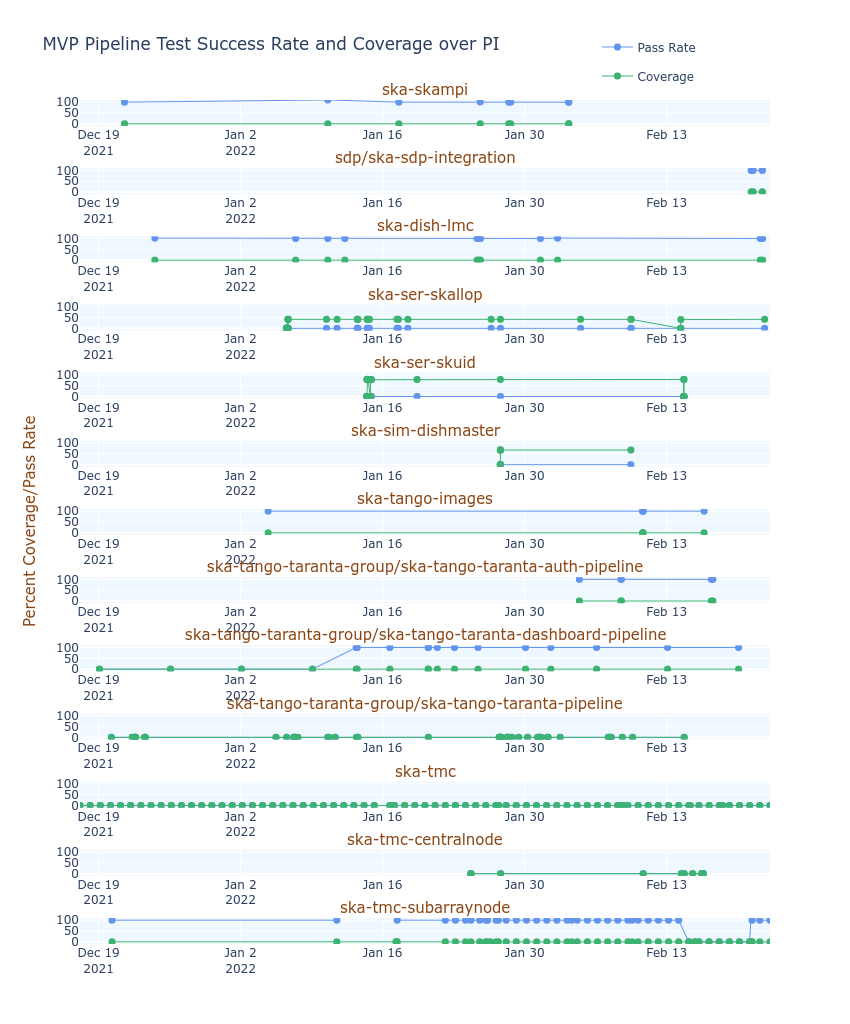

In [51]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=len(projects), 
                    cols=1, 
                    vertical_spacing = 0.05, 
                    subplot_titles = list(reversed(projects)),
                    y_title='Percent Coverage/Pass Rate',)

cnt = 0
yesno = True
for proj in projects:
    data_pass_rate = df_test_results[(df_test_results.project == proj) & (df_test_results.field == 'pass_rate')]
    data_coverage = df_test_results[(df_test_results.project == proj) & (df_test_results.field == 'coverage')]
    cnt = cnt + 1
    # pos = cnt*2
    fig.append_trace(go.Scatter(
        x=data_pass_rate.time, y=data_pass_rate.value, mode='lines+markers', marker=dict(size=7), line=dict(color='cornflowerblue', width=1),
     name="Pass Rate", showlegend=yesno,legendgroup="group1"), row=cnt, col=1)
    fig.append_trace(go.Scatter(
        x=data_coverage.time, y=data_coverage.value, mode='lines+markers', marker=dict(size=7), line=dict(color='mediumseagreen', width=1),
     name="Coverage", showlegend=yesno, legendgroup="group2"), row=cnt, col=1)
    fig.update_xaxes(range=[df_test_results.time.min(), df_test_results.time.max()], row=cnt, col=1)
    fig.update_yaxes(range=[-10, 110], row=cnt, col=1)
    yesno = False

fig.update_layout(height=1024, width=1024,
                  title_text="MVP Pipeline Test Pass Rate and Coverage over PI",
                  plot_bgcolor='aliceblue',
                  showlegend=True, legend=dict(
                                            yanchor="top",
                                            y=1.08,
                                            xanchor="left",
                                            x=0.75
                                        ))
fig.update_annotations(font=dict(size=15, color="saddlebrown"))
fig.show()
    

In [47]:
df =  df_pipelines_all[(df_pipelines_all.project == "ska-skampi") & (df_pipelines_all.status == "success")]
df = df[["_time", "_field", "_value", "status", "project"]].reset_index()
df = df.rename(columns={"_time": "time", "_value": "value", "_field": "field"})
df[(df.field != "coverage") & (df.field != "duration") & (df.field != "last_run")]

index                             time         field  value   status  \
99     944 2021-12-20 07:50:53.218000+00:00     pass_rate  100.0  success   
100    945 2022-01-11 11:33:58.442000+00:00     pass_rate  100.0  success   
101    957 2022-02-09 14:15:44.987000+00:00     pass_rate  100.0  success   
102   1101 2022-01-17 10:27:33.424000+00:00     pass_rate  100.0  success   
103   1120 2022-01-22 04:17:42.367000+00:00     pass_rate  100.0  success   
..     ...                              ...           ...    ...      ...   
292   2599 2022-02-14 04:26:51.587000+00:00  test_success    9.0  success   
293   2601 2022-02-22 04:26:31.425000+00:00  test_success    9.0  success   
294   2602 2022-02-23 04:27:07.332000+00:00  test_success    9.0  success   
295   2606 2022-02-21 10:00:11.376000+00:00  test_success    9.0  success   
296   2608 2022-01-27 09:52:48.006000+00:00  test_success    9.0  success   

        project  
99   ska-skampi  
100  ska-skampi  
101  ska-skampi  
102  ska-skampi  
103  ska-skampi  
..          ...  
292  ska-skampi  
293  ska-skampi  
294  ska-skampi  
295  ska-skampi  
296  ska-skampi  

[198 rows x 6 columns]